In [3]:
import pandas as pd
import nltk
df = pd.read_csv('clean_data1.csv', engine='python')
df = df.drop(['Resume'],axis=1)
df.rename(columns={'newer_res':'Resume'},inplace=True)
resume_punc = df["Resume"].copy(deep  = True)
df.head()
#resume_punc

,Unnamed: 0,ID,Category,Resume
0,0,1,HR,"john h. smith , p.h.r . 800-991-5187 | po box ..."
1,1,2,HR,name surname address mobile no/email personal ...
2,2,3,HR,anthony brown hr assistant areas of expertise ...
3,3,4,HR,www.downloadmela.com satheesh email id : caree...
4,4,5,HR,human resources director expert organizational...


In [4]:
import string
def rem_punc(s):
    punc = string.punctuation
    return [i for i in s if i not in punc]

In [5]:
print(df.columns)  # Check column names


Index(['Unnamed: 0', 'ID', 'Category', 'Resume'], dtype='object')


In [11]:
import re

def rem_punc(s):
    punc = string.punctuation
    return [i for i in s if i not in punc]

for ind, row in df.iterrows():  # Use iterrows for safe row iteration
    # Use regex to tokenize, finding sequences of word characters
    tokens = re.findall(r'\b\w+\b', row['Resume'])
    df.loc[ind, "Resume"] = " ".join(rem_punc(tokens))

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
import string
from wordcloud import STOPWORDS
def rem_punc(s):
    punc = string.punctuation
    return [i for i in s if i not in punc]

def rem_sw(s):
    sw = set(STOPWORDS)
    return [i for i in s if i not in sw]

def preprocess(eval_res):
    try:
        eval_res = eval(eval_res).decode()
    except:
        pass
    eval_res = eval_res.encode("ASCII","ignore").decode()
    length = len(eval_res)
    eval_res = " ".join(eval_res.split("\n"))
    token = rem_sw(nltk.word_tokenize(eval_res)) #Removing punctaution later since we need punctaution for sentence tokenization
    eval_res = " ".join(token).lower()
    return eval_res

In [14]:
from io import StringIO
col = ['Category', 'Resume']
df = df[col]
df = df[pd.notnull(df['Resume'])]
df.columns = ['Category', 'Resume']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

df.head()

,Category,Resume,category_id
0,HR,john h smith p h r 800 991 5187 po box 1673 ca...,0
1,HR,name surname address mobile no email personal ...,0
2,HR,anthony brown hr assistant areas of expertise ...,0
3,HR,www downloadmela com satheesh email id career ...,0
4,HR,human resources director expert organizational...,0


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.Resume).toarray()
labels = df.category_id
features.shape

(1199, 22086)

In [17]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    #print(feature_names)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n\t. {}".format('\n\t. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n\t. {}".format('\n\t. '.join(bigrams[-N:])))
    print("\n\n")
    #print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'Accountant':
  . Most correlated unigrams:
	. chartered
	. accountant
  . Most correlated bigrams:
	. chartered accountant
	. accountant resume



# 'Advocate':
  . Most correlated unigrams:
	. legal
	. law
  . Most correlated bigrams:
	. legal research
	. law school



# 'Agricultural':
  . Most correlated unigrams:
	. agriculture
	. horticulture
  . Most correlated bigrams:
	. pest control
	. achievement american



# 'Apparel':
  . Most correlated unigrams:
	. textiles
	. fashion
  . Most correlated bigrams:
	. fashion designer
	. space planning



# 'Architects':
  . Most correlated unigrams:
	. revit
	. drawings
  . Most correlated bigrams:
	. prepare drawings
	. auto cad



# 'Arts':
  . Most correlated unigrams:
	. artist
	. theatre
  . Most correlated bigrams:
	. make artist
	. special skills



# 'Automobile':
  . Most correlated unigrams:
	. automobile
	. automotive
  . Most correlated bigrams:
	. experience automotive
	. history 2007



# 'Aviation':
  . Most correlated u

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

x_train, x_test, y_train, y_test = train_test_split(df['Resume'], df['Category'], random_state = 0)

#print(x_train)

count_vect = CountVectorizer() # bag-of-ngrams model , based on frequency count
x_train_counts = count_vect.fit_transform(x_train)

tfidf_transformer = TfidfTransformer() #passing the word:word count
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

classifier = MultinomialNB().fit(x_train_tfidf, y_train)

In [21]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

def convertPDFtoText(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)
    fp.close()
    device.close()
    string = retstr.getvalue()
    retstr.close()
    return string

In [22]:
test_resume = convertPDFtoText("sample_input.pdf")
print(test_resume)

Dushyant Bhatt
BI / Big Data/ Azure

Hyderabad-Deccan, Telangana, Telangana - Email me on Indeed: indeed.com/r/Dushyant-
Bhatt/140749dace5dc26f

• 10+ years of Experience in Designing, Development, Administration, Analysis, Management in
the Business Intelligence Data warehousing, Client Server Technologies, Web-based Applications,
cloud solutions and Databases.
• Data warehouse: Data analysis, star/ snow flake schema data modeling and design specific to
data warehousing and business intelligence environment.
•  Database:  Experience  in  database  designing,  scalability,  back-up  and  recovery,  writing  and
optimizing SQL code and Stored Procedures, creating functions, views, triggers and indexes. 
• Cloud platform: Worked on Microsoft Azure cloud services like Document DB, SQL Azure, Stream
Analytics, Event hub, Power BI, Web Job, Web App, Power BI, Azure data lake analytics(U-SQL).
• Big Data: Worked Azure data lake store/analytics for big data processing and Azure data factory
t

In [23]:
from nltk.probability import FreqDist
from string import punctuation
import math
def summarize(doc,words):
    score={}
    fd = FreqDist(words)
    for i,t in enumerate(doc):
        score[i] = 0
        for j in nltk.word_tokenize(t):
            if j in fd:
                score[i]+=fd[j]

    r = sorted(list(score.items()),key=lambda x:x[1],reverse=True)[:math.floor(0.60*len(doc))]
    r.sort(key=lambda x:x[0])
    l = [doc[i[0]] for i in r]
    return "\n\n".join(l)

In [25]:
import nltk
import re # Import the re module
nltk.download('punkt') # Ensure punkt is downloaded

resume = preprocess(test_resume)#remove stop words etc
# Use regex for sentence tokenization
sent = re.split(r'[.!?]+', test_resume) # Split by common sentence-ending punctuation
sent = [s.strip() for s in sent if s.strip()] # Clean up empty strings and whitespace

puncu = punctuation
word_token = nltk.word_tokenize(test_resume)#tokenize preprocessed text for scoring

print(summarize(sent,word_token)) # Pass word_token to summarize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Dushyant Bhatt
BI / Big Data/ Azure

Hyderabad-Deccan, Telangana, Telangana - Email me on Indeed: indeed.com/r/Dushyant-
Bhatt/140749dace5dc26f

• 10+ years of Experience in Designing, Development, Administration, Analysis, Management in
the Business Intelligence Data warehousing, Client Server Technologies, Web-based Applications,
cloud solutions and Databases.

• Data warehouse: Data analysis, star/ snow flake schema data modeling and design specific to
data warehousing and business intelligence environment.

•  Database:  Experience  in  database  designing,  scalability,  back-up  and  recovery,  writing  and
optimizing SQL code and Stored Procedures, creating functions, views, triggers and indexes.

• Cloud platform: Worked on Microsoft Azure cloud services like Document DB, SQL Azure, Stream
Analytics, Event hub, Power BI, Web Job, Web App, Power BI, Azure data lake analytics(U-SQL).

• BI:
o  ETL:  Designed  and  developed  ETL  solution  in  SSIS.

Experience  in  Logging,  Err

In [26]:
print(classifier.predict(count_vect.transform([test_resume])))

['Information Technology']


In [20]:
!pip install pdfminer.six

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 63.1 MB/s eta 0:00:00


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/tmp/ipython-input-28-2264602041.py:5: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='model_name', y='accuracy', data=cv_df,


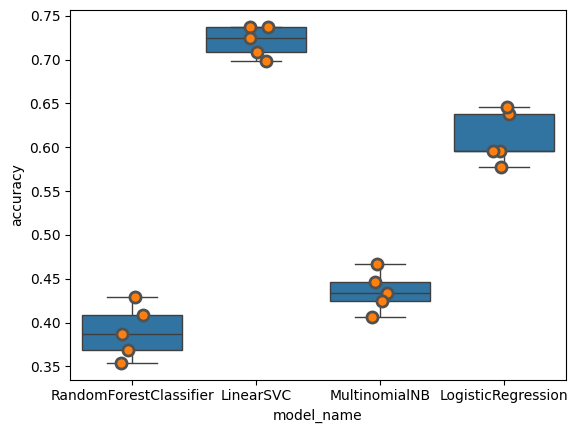

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [29]:
cv_df.groupby('model_name').accuracy.mean()

,accuracy
model_name,
LinearSVC,0.721416
LogisticRegression,0.610481
MultinomialNB,0.435338
RandomForestClassifier,0.389474


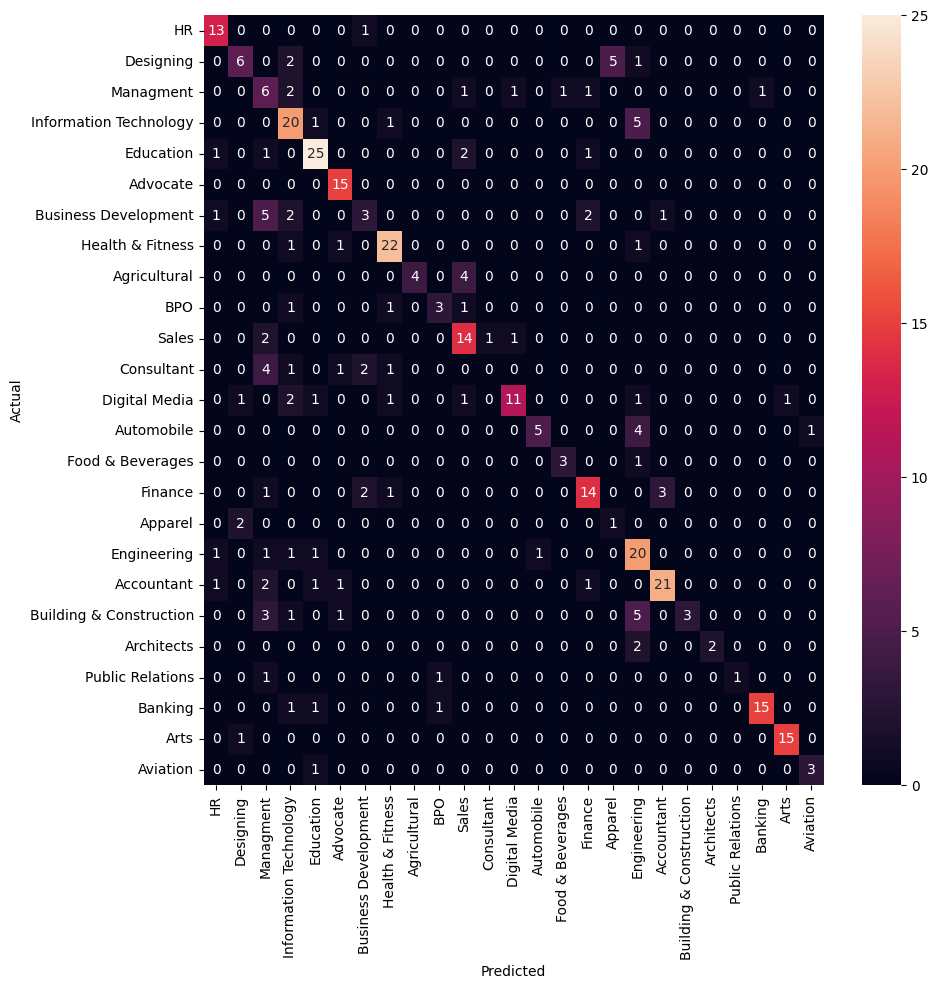

In [30]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.30, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()